# Libraries

In [2]:
## Useful libraries
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import os
import copy
import pickle
from urllib.request import urlretrieve
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from sklearn.preprocessing import MinMaxScaler
from matplotlib.colors import TwoSlopeNorm
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Additional input
import networkx as nx
from tqdm import tqdm
!pip install torch_geometric
from torch_geometric.data import Data
!pip install perlin-noise
from perlin_noise import PerlinNoise
import random
from loader import load_dataset
from datetime import datetime

from cycler import cycler
import seaborn as sns
import time

# Set the color scheme
sns.set_theme()
colors = ['#0076C2', '#EC6842', '#A50034', '#009B77', '#FFB81C', '#E03C31', '#6CC24A', '#EF60A3', '#0C2340', '#00B8C8', '#6F1D77']
plt.rcParams['axes.prop_cycle'] = cycler(color=colors)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from functions import *

# Dataset
The data folder comprises 4 subfolders (DEM, WD, VX, VY), containing the elevation, water depths in time, and velocities (in x and y directions) in time for all training and testing simulations. The overview.csv file provides the runtime of the numerical model on each different simulation, identified by its id.

- 1-80: Training and validation

- 501-520: Testing dataset 1

- 10001-10020: Testing dataset 2

- 15001-15020: Testing dataset 3

In [60]:
data_folder = 'raw_datasets/'

train_dataset = 'DEM/'

In [61]:
dataset_folder = data_folder
n_sim = 80
start_sim = 1
dataset_name = 'grid'

datasets_folder = 'datasets'
if not os.path.exists(datasets_folder):
    os.makedirs(datasets_folder)

dataset_dir = datasets_folder + '/train'


##################### Use this code to create local pickle file #####################
# pyg_dataset = create_grid_dataset(dataset_folder, n_sim=n_sim)
# save_database(pyg_dataset, name=dataset_name, out_path=dataset_dir)

# train_dataset = load_dataset(dataset_name=dataset_name, dataset_folder=dataset_dir)

In [62]:
train_url = "https://www.dropbox.com/scl/fi/krwlidaz5na0ci3mew6lr/grid.pkl?rlkey=0ie6h9bsb89g97razt0w3u82w&dl=1"

# retrieve data from url
if not os.path.isfile(datasets_folder):
    print("Downloading the pickled dataset...")
    train_path = os.path.join(datasets_folder, "grid.pkl")
    urlretrieve(train_url, train_path)

with open(train_path, 'rb') as f:
    train_dataset = pickle.load(f)

## Visualization

Start visualization of the data to get a better understanding

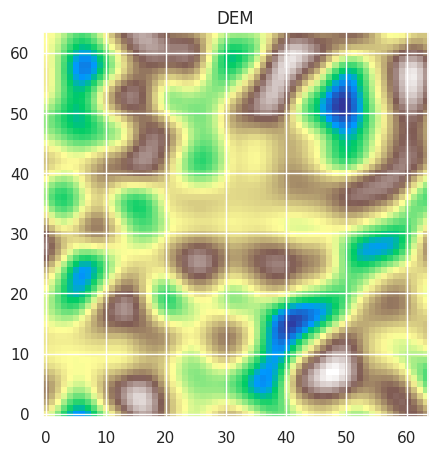

In [63]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
number_grids = 64

axs.imshow(train_dataset[0]['DEM'].reshape(number_grids,number_grids), cmap='terrain', origin='lower')
axs.set_title('DEM')

plt.show()
axs.clear()
plt.show()

# Normalization

Since the input and output values may have very different ranges, it is important to perform normalization to both.

In [64]:
def normalize_dataset(dataset, scaler_DEM, scaler_WD):

    min_DEM, max_DEM = scaler_DEM.data_min_[0], scaler_DEM.data_max_[0]
    min_WD, max_WD = scaler_WD.data_min_[0], scaler_WD.data_max_[0]
    normalized_dataset = []

    for idx in range(len(dataset)):
        DEM = dataset[idx]['DEM']
        WD = dataset[idx]['WD']
        norm_DEM = (DEM - min_DEM) / (max_DEM - min_DEM)
        norm_WD = (WD - min_WD) / (max_WD - min_WD)

        DEM = norm_DEM.reshape(64,64)
        WD = norm_WD[:,0].reshape(64,64)


        DEM = norm_DEM.reshape(64,64)
        WD = norm_WD[:,0].reshape(64,64)

        temp_dict = {}
        temp_dict['Input'] = torch.stack((DEM, WD), dim=0)

        WD_transposed = norm_WD[:, 1:].reshape(64,64, -1)
        WD_transposed = WD_transposed.transpose(0, 2)
        WD_transposed = WD_transposed.transpose(1, 2)
        temp_dict['WD'] = WD_transposed

        normalized_dataset.append(temp_dict)

    return normalized_dataset

In [65]:
# Normalize the inputs and outputs using training dataset
scaler_DEM = MinMaxScaler() # Can store DEM, VX, VY as one 'input' Scaler
scaler_WD = MinMaxScaler()

for index in range(len(train_dataset)): # =80
    scaler_DEM.partial_fit(train_dataset[index]['DEM'].reshape(-1, 1).cpu())
    scaler_WD.partial_fit(train_dataset[index]['WD'].reshape(-1, 1).cpu())

normalized_train_dataset = normalize_dataset(train_dataset, scaler_DEM, scaler_WD)

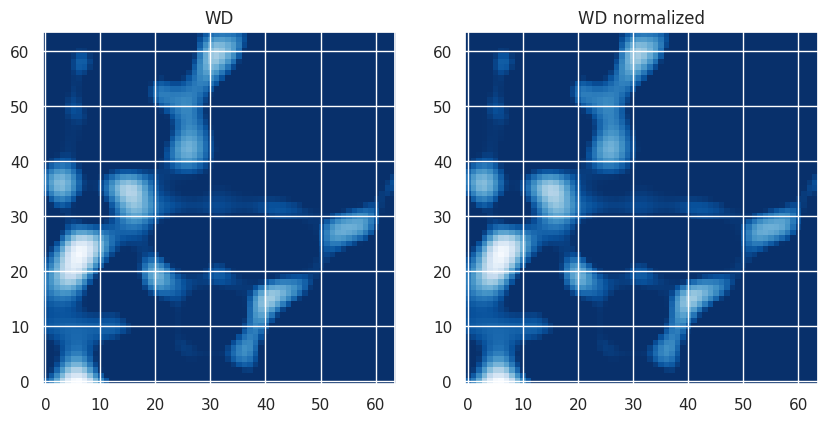

In [66]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(train_dataset[0]['WD'][:,-1].reshape(number_grids,number_grids), cmap='Blues_r', origin='lower')
axs[0].set_title('WD')

axs[1].imshow(normalized_train_dataset[0]['WD'][-1].reshape(number_grids,number_grids), cmap='Blues_r', origin='lower')
axs[1].set_title('WD normalized')
plt.show()

In [67]:
# Split dataset into train, validation, and testing
train_percnt = 0.8
train_size = int(train_percnt * len(train_dataset))
val_size = len(train_dataset) - train_size
training_dataset, val_dataset = random_split(normalized_train_dataset, [train_size, val_size])

In [68]:
# Dataset has two variables, training data DEM, target WD
print('Amount of variables', len(normalized_train_dataset[0]))
print(f'Size of WD data ({normalized_train_dataset[0]["WD"].shape})')

Amount of variables 2
Size of WD data (torch.Size([96, 64, 64]))


# Model

In [69]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, bias=False, batch_norm=True):
        super().__init__()

        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, bias=bias)]
        if batch_norm:
            layers.append(nn.BatchNorm2d(num_features=out_channels))
        layers.append(nn.PReLU())
        layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=padding, bias=bias))

        self.cnnblock = nn.Sequential(*layers)

    def forward(self, x):
        return self.cnnblock(x)

class Encoder(nn.Module):
    def __init__(self, channels=[32, 64, 128], kernel_size=3, padding=1, bias=False, batch_norm=True):
        super().__init__()

        self.enc_blocks = nn.ModuleList([
            CNNBlock(channels[block], channels[block+1], kernel_size, padding, bias,
                     batch_norm=batch_norm)
            for block in range(len(channels)-1)]
            )
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        outs = []
        for block in self.enc_blocks:
            x = block(x)
            outs.append(x)
            x = self.pool(x)
        return outs

class Decoder(nn.Module):
    def __init__(self, channels=[128, 64, 32], kernel_size=3, padding=1, bias=False, batch_norm=True):
        super().__init__()
        self.channels = channels
        self.upconvs = nn.ModuleList([
            nn.ConvTranspose2d(channels[block], channels[block+1], kernel_size=2, padding=0, stride=2)
            for block in range(len(channels)-1)]
            )
        self.dec_blocks = nn.ModuleList([
            CNNBlock(channels[block], channels[block+1], kernel_size, padding, bias,
                     batch_norm=batch_norm)
             for block in range(len(channels)-1)]
             )

    def forward(self, x, x_skips):
        for i in range(len(x_skips)):
            x = self.upconvs[i](x)
            x = torch.cat((x, x_skips[-(1+i)]), dim=1)
            x = self.dec_blocks[i](x)

        x = self.dec_blocks[-1](x)
        return x

class CNN(nn.Module):
    def __init__(self, node_features, out_dim=96, n_downsamples=3, initial_hid_dim=64, batch_norm=True,
                 bias=True):
        super(CNN, self).__init__()
        hidden_channels = [initial_hid_dim*2**i for i in range(n_downsamples)]
        encoder_channels = [node_features]+hidden_channels
        decoder_channels = list(reversed(hidden_channels))+[out_dim]

        self.encoder = Encoder(encoder_channels, kernel_size=3, padding=1,
                               bias=bias, batch_norm=batch_norm)
        self.decoder = Decoder(decoder_channels, kernel_size=3, padding=1,
                               bias=bias, batch_norm=batch_norm)

    def forward(self, x):
#         print('Forward: x input size', x.shape)
        x = self.encoder(x)
#         print(len(x))
        x = self.decoder(x[-1], x[:-1])
#         print(x.shape)
        x = nn.Sigmoid()(x)
#         print('Output shape', x.shape)
#         print('')
        return x

In [70]:
def train_epoch(model, loader, optimizer, device='cpu'):
    model.to(device)
    model.train() # specifies that the model is in training mode

    losses = []

    for batch in loader:

        x = batch['Input']   # [batch_size, channels, height, width]
        y = batch['WD']

        x = x.to(device)
        y = y.to(device)

        # Model prediction
        preds = model(x)

        # MSE loss function
        loss = nn.MSELoss()(preds, y)

        losses.append(loss.cpu().detach())

        # Backpropagate and update weights
        loss.backward()   # compute the gradients using backpropagation
        optimizer.step()  # update the weights with the optimizer
        optimizer.zero_grad(set_to_none=True)   # reset the computed gradients

    losses = np.array(losses).mean()

    return losses

In [71]:
def evaluation(model, loader, device='cpu'):
    model.to(device)
    model.eval() # specifies that the model is in evaluation mode

    losses = []

    with torch.no_grad():
        for batch in loader:
            x = batch['Input']
            y = batch['WD']  # [:,:,:,1]

            x = x.to(device)
            y = y.to(device)

            # Model prediction
            preds = model(x)

            # MSE loss function
            loss = nn.MSELoss()(preds, y)
            losses.append(loss.cpu().detach())

    losses = np.array(losses).mean()

    return losses

# Define hyperparameters and dataloaders

In [72]:
# define the model
node_features = 2
model = CNN(node_features=node_features, n_downsamples=4, initial_hid_dim=32,
            batch_norm=True, bias=True)

# Set training parameters
learning_rate = 0.0002
batch_size = 10 ### 1, 2, 4, 5, 8, 10, 16, 20, 40, or 80
num_epochs = 150

# Create the optimizer to train the neural network via back-propagation
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

# Create the training and validation dataloaders to "feed" data to the model in batches
train_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
#test_loader = DataLoader(normalized_test_dataset, batch_size=batch_size, shuffle=False)


# Training and validation

No improvement for 20 epochs
counter 20
No improvement for 20 epochs
counter 21
No improvement for 20 epochs
counter 22
No improvement for 20 epochs
counter 23
No improvement for 20 epochs
counter 24
No improvement for 20 epochs
counter 25
No improvement for 20 epochs
counter 26
No improvement for 20 epochs
counter 27
No improvement for 20 epochs
counter 28
No improvement for 20 epochs
counter 29
No improvement for 20 epochs
counter 30
No improvement for 20 epochs
counter 31
No improvement for 20 epochs
counter 32
No improvement for 20 epochs
counter 33
No improvement for 20 epochs
counter 34
epoch: 50 	 training loss: 0.0002 	 validation loss: 0.0014 	 best validation loss: 0.0013


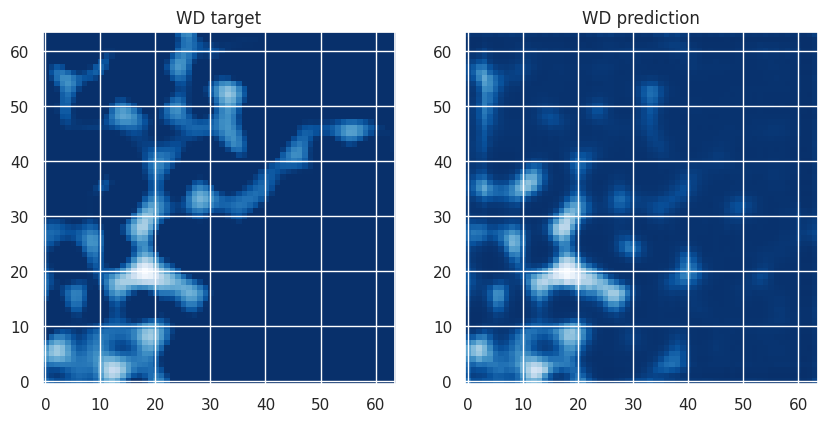

No improvement for 20 epochs
counter 35
No improvement for 20 epochs
counter 36
No improvement for 20 epochs
counter 37
No improvement for 20 epochs
counter 38
No improvement for 20 epochs
counter 39
No improvement for 20 epochs
counter 40
No improvement for 20 epochs
counter 41
No improvement for 20 epochs
counter 42
No improvement for 20 epochs
counter 43
No improvement for 20 epochs
counter 44
No improvement for 20 epochs
counter 45
No improvement for 20 epochs
counter 46
No improvement for 20 epochs
counter 47
No improvement for 20 epochs
counter 48
No improvement for 20 epochs
counter 49
No improvement for 20 epochs
counter 50
No improvement for 20 epochs
counter 51
No improvement for 20 epochs
counter 52
No improvement for 20 epochs
counter 53
No improvement for 20 epochs
counter 54
No improvement for 20 epochs
counter 55
No improvement for 20 epochs
counter 56
No improvement for 20 epochs
counter 57
No improvement for 20 epochs
counter 58
No improvement for 20 epochs
counter 59


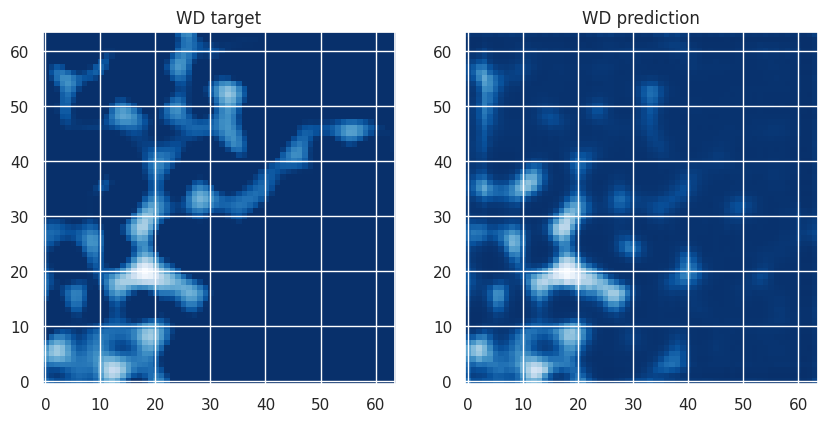

No improvement for 20 epochs
counter 85
No improvement for 20 epochs
counter 86
No improvement for 20 epochs
counter 87
No improvement for 20 epochs
counter 88
No improvement for 20 epochs
counter 89
No improvement for 20 epochs
counter 90
No improvement for 20 epochs
counter 20
No improvement for 20 epochs
counter 21
No improvement for 20 epochs
counter 22
No improvement for 20 epochs
counter 23
No improvement for 20 epochs
counter 24
No improvement for 20 epochs
counter 25
No improvement for 20 epochs
counter 26
No improvement for 20 epochs
counter 27
No improvement for 20 epochs
counter 28
No improvement for 20 epochs
counter 29
No improvement for 20 epochs
counter 30
No improvement for 20 epochs
counter 31
No improvement for 20 epochs
counter 32
No improvement for 20 epochs
counter 33
No improvement for 20 epochs
counter 34
No improvement for 20 epochs
counter 35
No improvement for 20 epochs
counter 36
No improvement for 20 epochs
counter 37
No improvement for 20 epochs
counter 38


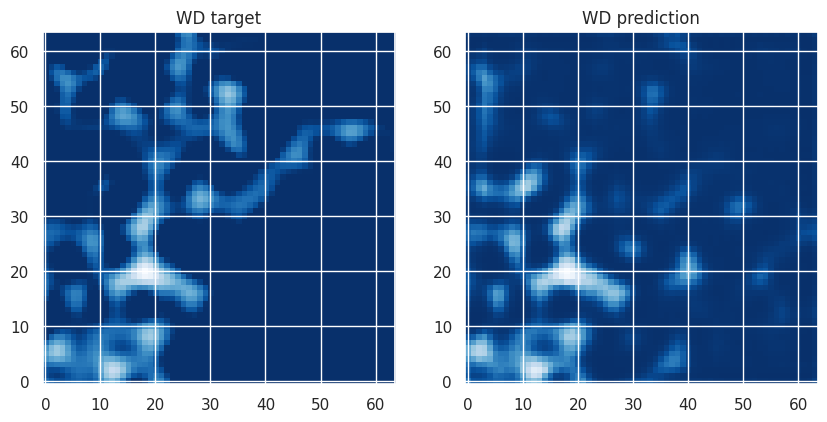

No improvement for 20 epochs
counter 45


In [75]:
#create vectors for the training and validation loss
train_losses = []
val_losses = []
no_improvement = 0

for epoch in range(1, num_epochs+1):
    # Model training
    train_loss = train_epoch(model, train_loader, optimizer, device=device)

    # Model validation
    val_loss = evaluation(model, val_loader, device=device)

    if epoch == 1:
        best_loss = val_loss

    if val_loss<=best_loss:
        best_model = copy.deepcopy(model)
        best_loss = val_loss
        best_epoch = epoch
        no_improvement = 0

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    no_improvement += 1

    if epoch%50 == 0:
        print("epoch:",epoch, "\t training loss:", np.round(train_loss,4),
                            "\t validation loss:", np.round(val_loss,4),
                            "\t best validation loss:", np.round(best_loss,4))

        # Plot prediction for one sample
        data_id = 4
        test_x = normalized_train_dataset[data_id]['Input'].reshape(1, 2, 64, 64)
        test_WD = normalized_train_dataset[data_id]['WD'][-1,:,:]

        test_x = test_x.to(device)

        # predict the WD
        pred_WD = best_model(test_x).detach()

        pred_last_WD = pred_WD[:,-1,:,:]

        show_WD = test_WD.reshape(64,64)
        show_pred_WD = pred_last_WD.reshape(64,64)

        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

        axs[0].imshow(show_WD.reshape(number_grids,number_grids), cmap='Blues_r', origin='lower')
        axs[0].set_title('WD target')

        axs[1].imshow(show_pred_WD.reshape(number_grids,number_grids).cpu(), cmap='Blues_r', origin='lower')
        axs[1].set_title('WD prediction')
        plt.show()

    if no_improvement >= 20:
        print('No improvement for 20 epochs')
        print('counter', no_improvement)


model = copy.deepcopy(best_model)

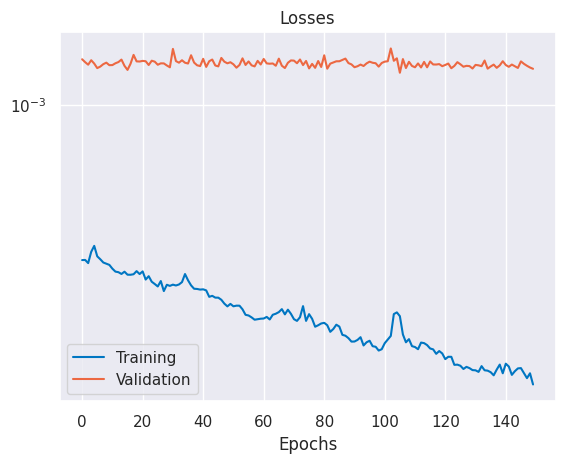

In [76]:
plt.plot(train_losses, label='Training')
plt.plot(val_losses, label='Validation')
plt.yscale('log')
plt.title('Losses')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [77]:
# Save model
models_folder = 'models'

if not os.path.exists(models_folder):
    os.makedirs(models_folder)

date_time = datetime.now().strftime("%D_%H%M%S")
date_time = date_time.replace('/', '_')
save_path = f'./models/model_{date_time}_lr_{learning_rate}_epochs_{num_epochs}_MSELoss.pth'
torch.save(model.state_dict(), save_path)

In [78]:
# select one sample
data_id = 70

print(normalized_train_dataset[data_id]['Input'].shape)
print(normalized_train_dataset[data_id]['WD'].shape)

torch.Size([2, 64, 64])
torch.Size([96, 64, 64])


In [ ]:
# # Load the best model after training is complete
# best_model_path = 'models/model_01_12_24_101357_lr_0.0002_epochs_100_MSELoss.pth'
# model.load_state_dict(torch.load(best_model_path))
# print("Loaded best model from:", best_model_path)

In [79]:
x = normalized_train_dataset[data_id]['Input'].reshape(1, 2, 64, 64)
WD = normalized_train_dataset[data_id]['WD'][-1,:,:]

# predict the WD
x = x.to(device)
pred_WD = model(x).detach()

# show_x = x.reshape(64,64)
show_WD = WD.reshape(64,64)

pred_last_WD = pred_WD[:,-1,:,:]
show_pred_WD = pred_last_WD.reshape(64,64)

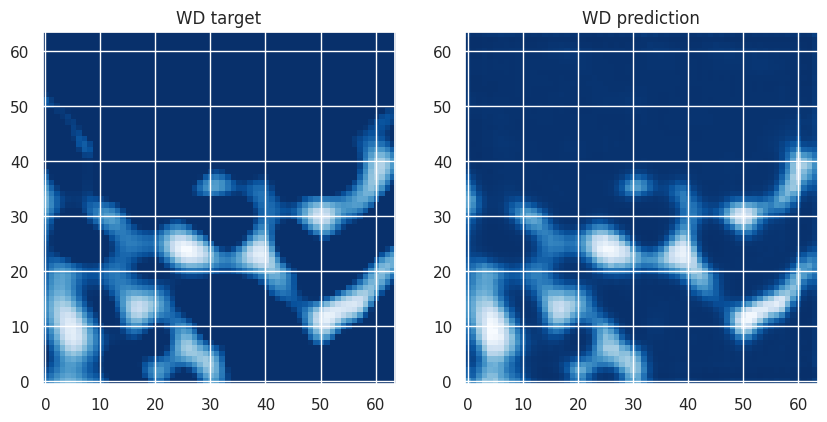

In [80]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(show_WD.reshape(number_grids,number_grids), cmap='Blues_r', origin='lower')
axs[0].set_title('WD target')

axs[1].imshow(show_pred_WD.reshape(number_grids,number_grids).cpu(), cmap='Blues_r', origin='lower')
axs[1].set_title('WD prediction')
plt.show()

In [81]:
def update(w, s):
    '''
    Function that creates an interactive plot for the four variables
    w: Timestep
    s: Sample

    '''
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].set_title(f'WD target, t={w+1}')
    axs[1].set_title(f'WD prediction t={w+1}')

    x = normalized_train_dataset[s]['Input'].reshape(1, 2, 64, 64)
    WD = normalized_train_dataset[s]['WD'][w,:,:]

    x = x.to(device)

    # predict the WD
    pred_WD = model(x).detach()
    pred_WD = pred_WD.cpu()

    # show_x = x.reshape(64,64)
    show_WD = WD.reshape(64,64)

    pred_last_WD = pred_WD[:,w,:,:]
    show_pred_WD = pred_last_WD.reshape(64,64)

    axs[0].imshow(show_WD, cmap='Blues_r', origin='lower')
    axs[1].imshow(show_pred_WD, cmap='Blues_r', origin='lower')
    plt.show()
#     fig.canvas.draw_idle()

interact(update, w=widgets.IntSlider(min=0, max=95, step=1, value=0), s=np.arange(0, n_sim-1));

interactive(children=(IntSlider(value=0, description='w', max=95), Dropdown(description='s', options=(0, 1, 2,…

In [82]:
def update(w, s):
    '''
    Function that creates an interactive plot for the four variables
    w: Timestep
    s: Sample

    '''
    fig, axs = plt.subplots(1, 4, figsize=(17,5))

    x = normalized_train_dataset[s]['Input'].reshape(1, 2, 64, 64)
    WD = normalized_train_dataset[s]['WD'][w,:,:]

    DEM = x[:,0]

    x = x.to(device)

    # predict the WD
    pred_WD = model(x).detach()
    pred_WD = pred_WD.cpu()

    # show_x = x.reshape(64,64)
    WD = WD.reshape(64,64)

    pred_last_WD = pred_WD[:,w,:,:]
    show_pred_WD = pred_last_WD.reshape(64,64)

    diff_FAT = WD - show_pred_WD
    max_FAT = max(show_pred_WD.max(), WD.max())
    max_diff = max(diff_FAT.max(), -diff_FAT.min())

    axs[0].imshow(DEM.squeeze(), cmap='terrain', origin='lower')
    axs[1].imshow(WD, vmin = 0, vmax=max_FAT, cmap='Blues_r', origin='lower')
    axs[2].imshow(show_pred_WD, vmin = 0, vmax=max_FAT, cmap='Blues_r', origin='lower')
    axs[3].imshow(diff_FAT, vmin =-max_diff, vmax=max_diff, cmap='RdBu', origin='lower')
    plt.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin = DEM.min(), vmax=DEM.max()),
                                cmap='terrain'), fraction=0.05, shrink=0.9, ax=axs[0])
    plt.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin = 0, vmax=max_FAT),
                                cmap='Blues_r'), fraction=0.05, shrink=0.9, ax=axs[1])
    plt.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin = 0, vmax=max_FAT),
                                cmap='Blues_r'), fraction=0.05, shrink=0.9, ax=axs[2])
    plt.colorbar(plt.cm.ScalarMappable(norm=TwoSlopeNorm(vmin=-max_diff, vmax=max_diff, vcenter=0),
                                cmap='RdBu'), fraction=0.05, shrink=0.9, ax=axs[3])

    for ax in axs:
        ax.axis('off')

    axs[0].set_title('DEM')
    axs[1].set_title(f'WD target, t={w+1}')
    axs[2].set_title(f'WD prediction t={w+1}')
    axs[3].set_title(f'WD difference, t={w+1}')
    plt.tight_layout()
    plt.show()

interact(update, w=widgets.IntSlider(min=0, max=95, step=1, value=0), s=np.arange(0, n_sim-1));

interactive(children=(IntSlider(value=0, description='w', max=95), Dropdown(description='s', options=(0, 1, 2,…

# Sensitivity analysis for Tweaking Hyperparameter

This sensitivity analysis is done with a brute force method to find the best hyperparameters. The following hyperparameters are tweaked around the default hyperparameter settings.

- `learning_rate = 0.0002`
- `batch_size = 8`
- `num_epoch = 150`

In [112]:
hyperparameters = {
    'learning_rate': [0.00005, 0.0001, 0.0002, 0.0004, 0.0008, 0.001],
    'batch_size': [1, 2, 4, 5, 8, 10, 16, 20, 40, 80],
    'num_epoch': [20, 100, 500]
}

def grid_search(hyperparameters, training_dataset, val_dataset):
  '''
  function to do a sensitivity analysis in grid search way
  hyperparameter is a list of hyperparameter space that one try to do sensitivity analysis
  '''
  # define array to store best model losses
  results = []
  total_iterations = len(hyperparameters['learning_rate']) * len(hyperparameters['batch_size']) * len(hyperparameters['num_epoch'])

  with tqdm(total=total_iterations, desc="Grid Search Progress") as pbar:
    for learning_rate in hyperparameters['learning_rate']:
      for batch_size in hyperparameters['batch_size']:
        for num_epochs in hyperparameters['num_epoch']:
          # reset parameter with re-define the model
          node_features = 2
          model = CNN(node_features=node_features, n_downsamples=4, initial_hid_dim=32,
                      batch_norm=True, bias=True)

          # Create the optimizer to train the neural network via back-propagation
          optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

          # Create the training and validation dataloaders to "feed" data to the model in batches
          train_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
          val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
          #test_loader = DataLoader(normalized_test_dataset, batch_size=batch_size, shuffle=False)

          # with tqdm(total=num_epochs, desc="Epoch Progress") as pepoch:
          for epoch in range(1, num_epochs+1):
              # Model training
              train_loss = train_epoch(model, train_loader, optimizer, device=device)

              # Model validation
              val_loss = evaluation(model, val_loader, device=device)

              if epoch == 1:
                  best_loss = val_loss

              if val_loss<=best_loss:
                  best_model = copy.deepcopy(model)
                  best_loss = val_loss
                  best_trainloss = train_loss
                  best_epoch = epoch
                # pepoch.update(1)
          # pepoch.close()

          results.append([learning_rate, batch_size, num_epochs, best_trainloss, best_loss])
          pbar.update(1)

    return results

In [85]:
sensitivity = grid_search(hyperparameters, training_dataset, val_dataset)

Grid Search Progress:   0%|          | 0/60 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [109]:
# save sensitivity analysis result in pickle file
with open('sensitivity.pkl', 'wb') as file:
  pickle.dump(sensitivity,file)

In [105]:
# load the pickeled sensitivity
sensitivity_url = "https://www.dropbox.com/scl/fi/qy9j7yn7dgbd709g7h8mr/sensitivity.pkl?rlkey=900badlri7qclj0obxjuxg3o0&dl=1"

result_folder = 'result/'

if not os.path.exists(result_folder):
    os.makedirs(result_folder)

# retrieve data from url
if not os.path.isfile(result_folder):
    print("Downloading the pickled dataset...")
    sensitivity_path = os.path.join(result_folder, "sensitivity.pkl")
    urlretrieve(sensitivity_url, sensitivity_path)

with open(sensitivity_path, 'rb') as f:
    sensitivity = pickle.load(f)

In [110]:
import pandas as pd
sensitivity_df = pd.DataFrame(sensitivity, columns=['learning_rate', 'batch_size', 'num_epochs', 'best_trainloss', 'best_loss'])
sensitivity_df.head()

,learning_rate,batch_size,num_epochs,best_trainloss,best_loss
0,0.00005,1,20,0.001222,0.002250
1,0.00005,1,100,0.000164,0.001540
2,0.00005,2,20,0.002882,0.003410
3,0.00005,2,100,0.000353,0.001633
4,0.00005,4,20,0.006538,0.007301


In [137]:
sensitivity_df.loc[(sensitivity_df['best_loss'] == min(sensitivity_df['best_loss']))]

,learning_rate,batch_size,num_epochs,best_trainloss,best_loss
165,0.0008,10,500,0.000168,0.001111


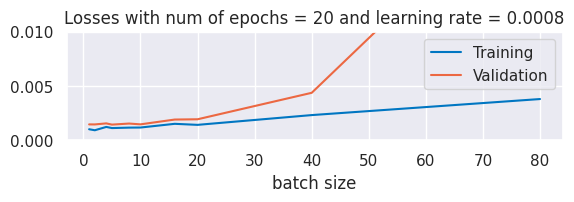

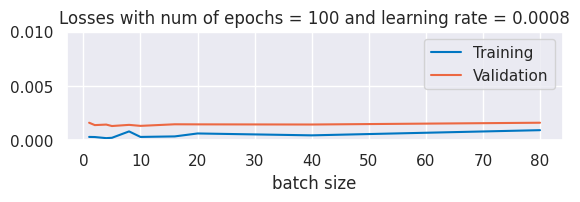

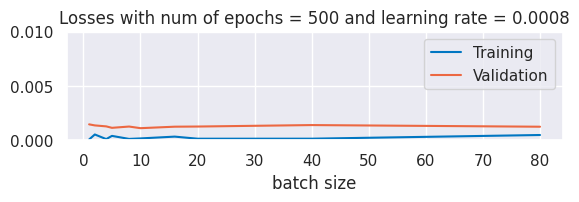

In [138]:
# batch size sensitivity analysis
# plt.figure(figsize=(10,15))

plt.subplot(3,1,1)
plt.plot(hyperparameters['batch_size'],
         sensitivity_df['best_trainloss'][(sensitivity_df['learning_rate']==hyperparameters['learning_rate'][4]) & (sensitivity_df['num_epochs']==hyperparameters['num_epoch'][0])],
         label='Training')
plt.plot(hyperparameters['batch_size'],
         sensitivity_df['best_loss'][(sensitivity_df['learning_rate']==hyperparameters['learning_rate'][4]) & (sensitivity_df['num_epochs']==hyperparameters['num_epoch'][0])],
         label='Validation')
plt.title(f"Losses with num of epochs = {hyperparameters['num_epoch'][0]} and learning rate = {hyperparameters['learning_rate'][4]}")
plt.ylim(0,0.01)
plt.xlabel('batch size')
plt.legend()
plt.show()

plt.subplot(3,1,2)
plt.plot(hyperparameters['batch_size'],
         sensitivity_df['best_trainloss'][(sensitivity_df['learning_rate']==hyperparameters['learning_rate'][4]) & (sensitivity_df['num_epochs']==hyperparameters['num_epoch'][1])],
         label='Training')
plt.plot(hyperparameters['batch_size'],
         sensitivity_df['best_loss'][(sensitivity_df['learning_rate']==hyperparameters['learning_rate'][4]) & (sensitivity_df['num_epochs']==hyperparameters['num_epoch'][1])],
         label='Validation')
plt.title(f"Losses with num of epochs = {hyperparameters['num_epoch'][1]} and learning rate = {hyperparameters['learning_rate'][4]}")
plt.ylim(0,0.01)
plt.xlabel('batch size')
plt.legend()
plt.show()

plt.subplot(3,1,3)
plt.plot(hyperparameters['batch_size'],
         sensitivity_df['best_trainloss'][(sensitivity_df['learning_rate']==hyperparameters['learning_rate'][4]) & (sensitivity_df['num_epochs']==hyperparameters['num_epoch'][2])],
         label='Training')
plt.plot(hyperparameters['batch_size'],
         sensitivity_df['best_loss'][(sensitivity_df['learning_rate']==hyperparameters['learning_rate'][4]) & (sensitivity_df['num_epochs']==hyperparameters['num_epoch'][2])],
         label='Validation')
plt.title(f"Losses with num of epochs = {hyperparameters['num_epoch'][2]} and learning rate = {hyperparameters['learning_rate'][4]}")
plt.ylim(0,0.01)
plt.xlabel('batch size')
plt.legend()
plt.show()

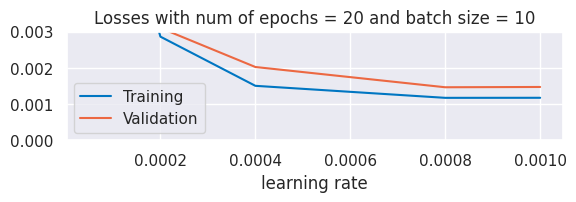

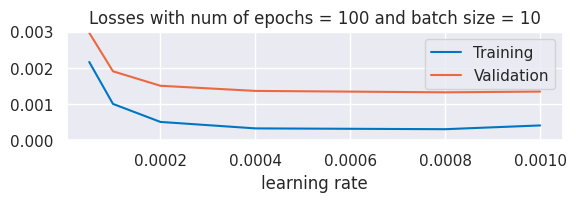

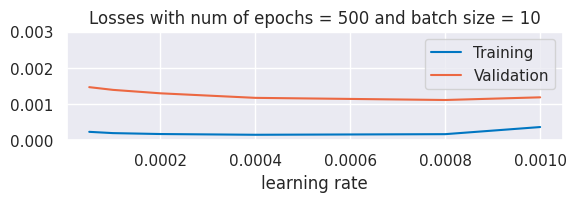

In [139]:
# learning rate sensitivity analysis

plt.subplot(3,1,1)
plt.plot(hyperparameters['learning_rate'],
         sensitivity_df['best_trainloss'][(sensitivity_df['batch_size']==hyperparameters['batch_size'][5]) & (sensitivity_df['num_epochs']==hyperparameters['num_epoch'][0])],
         label='Training')
plt.plot(hyperparameters['learning_rate'],
         sensitivity_df['best_loss'][(sensitivity_df['batch_size']==hyperparameters['batch_size'][5]) & (sensitivity_df['num_epochs']==hyperparameters['num_epoch'][0])],
         label='Validation')
plt.title(f"Losses with num of epochs = {hyperparameters['num_epoch'][0]} and batch size = {hyperparameters['batch_size'][5]}")
plt.ylim(0,0.003)
plt.xlabel('learning rate')
plt.legend()
plt.show()

plt.subplot(3,1,2)
plt.plot(hyperparameters['learning_rate'],
         sensitivity_df['best_trainloss'][(sensitivity_df['batch_size']==hyperparameters['batch_size'][5]) & (sensitivity_df['num_epochs']==hyperparameters['num_epoch'][1])],
         label='Training')
plt.plot(hyperparameters['learning_rate'],
         sensitivity_df['best_loss'][(sensitivity_df['batch_size']==hyperparameters['batch_size'][5]) & (sensitivity_df['num_epochs']==hyperparameters['num_epoch'][1])],
         label='Validation')
plt.title(f"Losses with num of epochs = {hyperparameters['num_epoch'][1]} and batch size = {hyperparameters['batch_size'][5]}")
plt.ylim(0,0.003)
plt.xlabel('learning rate')
plt.legend()
plt.show()

plt.subplot(3,1,3)
plt.plot(hyperparameters['learning_rate'],
         sensitivity_df['best_trainloss'][(sensitivity_df['batch_size']==hyperparameters['batch_size'][5]) & (sensitivity_df['num_epochs']==hyperparameters['num_epoch'][2])],
         label='Training')
plt.plot(hyperparameters['learning_rate'],
         sensitivity_df['best_loss'][(sensitivity_df['batch_size']==hyperparameters['batch_size'][5]) & (sensitivity_df['num_epochs']==hyperparameters['num_epoch'][2])],
         label='Validation')
plt.title(f"Losses with num of epochs = {hyperparameters['num_epoch'][2]} and batch size = {hyperparameters['batch_size'][5]}")
plt.ylim(0,0.003)
plt.xlabel('learning rate')
plt.legend()
plt.show()

In [136]:
sensitivity_df.loc[(sensitivity_df['learning_rate'] == 0.0008) & (sensitivity_df['batch_size'] == 8)]

,learning_rate,batch_size,num_epochs,best_trainloss,best_loss
88,0.0008,8,20,0.001162,0.001536
89,0.0008,8,100,0.000814,0.001415
164,0.0008,8,500,0.000123,0.001261


In [135]:
sensitivity_df.loc[(sensitivity_df['learning_rate'] == 0.0008) & (sensitivity_df['batch_size'] == 10)]

,learning_rate,batch_size,num_epochs,best_trainloss,best_loss
90,0.0008,10,20,0.001170,0.001462
91,0.0008,10,100,0.000305,0.001323
165,0.0008,10,500,0.000168,0.001111
